This notebook use for tunning model using embeddings file and language model embedder

### Check GPU hardware

In [1]:
!nvidia-smi

Mon Mar  7 09:54:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 60%   56C    P2   112W / 170W |  11868MiB / 12053MiB |     79%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download embedding files

In [2]:
# # Download file seq2tensor.py for converting protein sequences to tensors
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/seq2tensor.py

# # Download file ac5_aph.txt for ac5_aph embedding 
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/ac5_aph.txt

# ### Download interaction pairs and dictionary files
# # Download dictionary file (id: sequence)
# # !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/yeast/preprocessed/protein_dictionary.tsv
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Benchmarking-datasets/Pan2010/pan_train.tsv
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Benchmarking-datasets/Pan2010/pan_test.tsv

# # !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/yeast/yeast_DSCRIPT/yeast_dictionary.tsv

# # Download pairs of proteins with labels file
# # !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/yeast/preprocessed/protein_pairs.tsv
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Benchmarking-datasets/Pan2010/pan_proteins.tsv
# # !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/yeast/yeast_DSCRIPT/yeast_pairs.tsv

### Import libraries 

In [3]:
# Libraries for system and debug
import sys
import pdb
import os
from datetime import datetime

# Class for converting sequences to tensors
from seq2tensor import s2t

# Libraries for neural network training
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Input, Conv1D, Conv2D
from tensorflow.keras.layers import Add, Flatten, subtract, multiply, concatenate
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras import mixed_precision
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import train_test_split


# Import accessory modules
import numpy as np
import h5py
import gc
from tqdm import tqdm

### Set CUDA environment variables

In [4]:
### Setting RAM GPU for training growth 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-03-07 09:38:39.870122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 09:38:40.261553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10243 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
# ============================================
# Optimisation Flags - Do not remove
# ============================================

# Disables caching (when set to 1) or enables caching (when set to 0) for just-in-time-compilation. When disabled,
# no binary code is added to or retrieved from the cache.
os.environ['CUDA_CACHE_DISABLE'] = '0' # orig is 0

# When set to 1, forces the device driver to ignore any binary code embedded in an application 
# (see Application Compatibility) and to just-in-time compile embedded PTX code instead.
# If a kernel does not have embedded PTX code, it will fail to load. This environment variable can be used to
# validate that PTX code is embedded in an application and that its just-in-time compilation works as expected to guarantee application 
# forward compatibility with future architectures.
os.environ['CUDA_FORCE_PTX_JIT'] = '1'# no orig


os.environ['HOROVOD_GPU_ALLREDUCE'] = 'NCCL'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_GPU_THREAD_COUNT']='1'

os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'

os.environ['TF_ADJUST_HUE_FUSED'] = '1'
os.environ['TF_ADJUST_SATURATION_FUSED'] = '1'
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

os.environ['TF_SYNC_ON_FINISH'] = '0'
os.environ['TF_AUTOTUNE_THRESHOLD'] = '2'
os.environ['TF_DISABLE_NVTX_RANGES'] = '1'
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"



# =================================================
# mixed_precision.set_global_policy('mixed_float16')

### Define custom function

In [6]:
def generator_pair(seq_tensor, class_labels, pair_index):
    for index in pair_index:
        yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]

def generator_pair_predict(seq_tensor, class_labels, pair_index):
    for index in pair_index:
        yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}

def input_preprocess(id2seq_file, ds_file, use_emb):
    id2index = {}
    seqs = []
    index = 0
    sid1_index = 0
    sid2_index = 1
    label_index = 2
    
    for line in open(id2seq_file):
        line = line.strip().split('\t')
        id2index[line[0]] = index
        seqs.append(line[1])
        index += 1

    seq_array = []
    id2_aid = {}
    sid = 0

    seq2t = s2t(use_emb)
    max_data = -1
    limit_data = max_data > 0
    raw_data = []
    skip_head = True
    x = None
    count = 0
    
    # Create sequence array as a list of protein strings
    for line in tqdm(open(ds_file)):
        if skip_head:
            skip_head = False
            continue
        line = line.rstrip('\n').rstrip('\r').split('\t')
        if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
            continue
        if id2_aid.get(line[sid1_index]) is None:
            id2_aid[line[sid1_index]] = sid
            sid += 1
            seq_array.append(seqs[id2index[line[sid1_index]]])
        line[sid1_index] = id2_aid[line[sid1_index]]
        if id2_aid.get(line[sid2_index]) is None:
            id2_aid[line[sid2_index]] = sid
            sid += 1
            seq_array.append(seqs[id2index[line[sid2_index]]])
        line[sid2_index] = id2_aid[line[sid2_index]]
        raw_data.append(line)
        if limit_data:
            count += 1
            if count >= max_data:
                break

    len_m_seq = np.array([len(line.split()) for line in seq_array])
    avg_m_seq = int(np.average(len_m_seq)) + 1
    max_m_seq = max(len_m_seq)
    dim = seq2t.dim

    # seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
    # Random for distribution of class labels
    seq_tensor = np.array([seq2t.embed_normalized(line, seq_size)
                          for line in tqdm(seq_array)]).astype('float16')

    # Extract index of 1st and 2nd sequences in pairs
    seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
    seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

    # Assign labels for pairs of sequences
    class_map = {'0': 1, '1': 0}
    class_labels = np.zeros((len(raw_data), 2))
    for i in range(len(raw_data)):
        class_labels[i][class_map[raw_data[i][label_index]]] = 1
        
    return seq_tensor, seq_index1, seq_index2, class_labels, dim

def leaky_relu(x, alpha = .3):
    return tf.keras.backend.maximum(alpha*x, x)

def build_model(hparams):
    # Input of sequence tensor representations 
    seq_input1 = Input(shape=(seq_size, dim), name='seq1')
    seq_input2 = Input(shape=(seq_size, dim), name='seq2')

    # Define Conv1D and Bi-RNN (GRU/LSTM) use in architecture
    l1=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r1=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l2=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r2=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l3=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r3=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l4=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r4=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l5=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r5=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l6=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    
    # Siamese architecture

    ### 1st sibling

    # 1st Block RCNN 
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l1(seq_input1))
    s1=concatenate([r1(s1), s1])

    # 2nd Block RCNN
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l2(s1))
    s1=concatenate([r2(s1), s1])

    # 3rd Block RCNN
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l3(s1))
    s1=concatenate([r3(s1), s1])

    # 4th Block RCNN 
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l4(s1))
    s1=concatenate([r4(s1), s1])

    # 5th Block RCNN
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l5(s1))
    s1=concatenate([r5(s1), s1])
    
    # Last convolution
    s1=l6(s1)
    s1=GlobalAveragePooling1D()(s1)

    ### 2nd sibling

    # 1st block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l1(seq_input2))
    s2=concatenate([r1(s2), s2])

    # 2nd block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l2(s2))
    s2=concatenate([r2(s2), s2])

    # 3rd block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l3(s2))
    s2=concatenate([r3(s2), s2])

    # 4th block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l4(s2))
    s2=concatenate([r4(s2), s2])

    # 5th block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l5(s2))
    s2=concatenate([r5(s2), s2])

    # Last convolution
    s2=l6(s2)
    s2=GlobalAveragePooling1D()(s2)

    ### Combine two siblings of siamese architecture
    merge_text = multiply([s1, s2])
    

    #### MLP Part
    # Set initializer
    
    # First dense
    x = Dense(hparams[HP_FIRST_DENSE], activation=hparams[HP_ACTIVATION])(merge_text)
    # x = tf.keras.layers.LeakyReLU(alpha=.3)(x)
    x = Dropout(hparams[HP_DROPOUT])(x)

    # Second dense
    x = Dense(int((hparams[HP_CONV_HIDDEN_DIM]+7)/2), activation=hparams[HP_ACTIVATION])(x)
    # x = tf.keras.layers.LeakyReLU(alpha=.3)(x)
    x = Dropout(hparams[HP_DROPOUT])(x)

    # Last softmax
    main_output = Dense(2, activation='softmax')(x)

    # Combine to form functional model
    merge_model = Model(inputs=[seq_input1, seq_input2], outputs=[main_output])
    return merge_model

In [7]:
# Default hyperparameters
CONV_HIDDEN_DIM = 50
RNN_HIDDEN = 50
N_EPOCHS = 50
HIDDEN_DIM=50
BATCH_SIZE = 32
DTYPE='float16'
LEARNING_RATE=.001
EPSILON=1e-6
adam = Adam(learning_rate=LEARNING_RATE, amsgrad=True, epsilon=EPSILON)
MAX_DATASET_SIZE = 11187
DATASET_SIZE = MAX_DATASET_SIZE
KERNEL_SIZE = 3
POOLING_KERNEL = 3
seq_size=3000
dim = 1024
get_custom_objects().update({'leaky_relu': leaky_relu})

# 1 for language model embedding
flags_embedding = 0
# 1 for loading from drive
available_data = 0

cross_validation = 0

In [8]:
# input_preprocess(id2seq_file="../data/pan_proteins.tsv", ds_file="../data/pan_train.tsv", use_emb="../data/ac5_aph.txt")
# train
seq_tensor, seq_index1, seq_index2, class_labels = input_preprocess(id2seq_file="../data/pan_proteins.tsv", ds_file="../data/pan_train.tsv", use_emb="../data/ac5_aph.txt")

# test
seq_tensor_, seq_index1_, seq_index2_, class_labels_ = input_preprocess(id2seq_file="../data/pan_proteins.tsv", ds_file="../data/pan_test.tsv", use_emb="../data/ac5_aph.txt")


56092it [00:00, 830325.44it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 55905/55905 [00:00<00:00, 4471530.07it/s]


ValueError: too many values to unpack (expected 4)

### Search for optimal configurations

In [9]:
HP_EPSILON = hp.HParam('epsilon', hp.Discrete([1e-6]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-3]))
HP_FIRST_DENSE = hp.HParam('first_dense', hp.Discrete([100]))
HP_KERNEL_SIZE = hp.HParam('kernel_size', hp.Discrete([3]))
HP_POOLING_KERNEL = hp.HParam('pooling_kernel', hp.Discrete([3]))
HP_CONV_HIDDEN_DIM = hp.HParam('conv_hidden_dim', hp.Discrete([50]))
HP_RNN_HIDDEN_DIM = hp.HParam('rnn_hidden_dim', hp.Discrete([50]))
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['leaky_relu']))
HP_ACTIVATION_CONV = hp.HParam('activation_conv', hp.Discrete(['linear']))
HP_REGULARIZER = hp.HParam('regularizer', hp.Discrete([0]))
HP_CONV_PADDING = hp.HParam('conv_padding', hp.Discrete(['valid']))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0e-1]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([256]))
HP_LEAKY_RELU = hp.HParam('leaky_relu', hp.Discrete([3e-1]))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_EPSILON,HP_LEARNING_RATE,HP_FIRST_DENSE, HP_KERNEL_SIZE, HP_POOLING_KERNEL, HP_CONV_HIDDEN_DIM, HP_RNN_HIDDEN_DIM, HP_ACTIVATION, HP_ACTIVATION_CONV, HP_REGULARIZER, HP_CONV_PADDING, HP_DROPOUT, HP_BATCH_SIZE, HP_LEAKY_RELU],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

### Hyperparameter set by default

In [10]:
# Default hyperparameters
CONV_HIDDEN_DIM = 50
RNN_HIDDEN = 50
N_EPOCHS = 50
HIDDEN_DIM=50
BATCH_SIZE = 32
DTYPE='float16'
LEARNING_RATE=.001
EPSILON=1e-6
adam = Adam(learning_rate=LEARNING_RATE, amsgrad=True, epsilon=EPSILON)
MAX_DATASET_SIZE = 11187
DATASET_SIZE = MAX_DATASET_SIZE
KERNEL_SIZE = 3
POOLING_KERNEL = 3
seq_size=3000
dim = 1024
# 1 for language model embedding
flags_embedding = 0
# 1 for loading from drive
available_data = 0

cross_validation = 0

### Split the dataset

In [ ]:
# Choose protein language model for embedder
from Bio import SeqIO # From Biopython library import SeqIO module to handle sequences when read and write different file formats

# Chooose language model embedder class from package bio-embeddings -> moduel embed
# from bio_embeddings.embed import CPCProtEmbedder, ProtTransT5XLU50Embedder, FastTextEmbedder, GloveEmbedder, PLUSRNNEmbedder, ProtTransBertBFDEmbedder, SeqVecEmbedder, UniRepEmbedder, Word2VecEmbedder, ProtTransXLNetUniRef100Embedder
#   from bio_embeddings.embed import ProtTransBertBFDEmbedder
from bio_embeddings.embed import ProtTransBertBFDEmbedder
embedder = ProtTransBertBFDEmbedder()

In [ ]:
# Download raw sequences and create a list of sequences
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Benchmarking-datasets/Pan2010/protein_seqs.txt
with open('protein_seqs.txt') as file:
    sequences = file.readlines()
    sequences = [sequence.rstrip() for sequence in sequences]

# Install in the case of using A100 for pytorch compatibility\
A100_status = !nvidia-smi | grep 'A100'
if A100_status:
    !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

# embeddings = []
# for sequence in sequences:
#     embeddings.append(embedder.embed(sequence))

# # Start embedding 
# # Embedding in generator form, need to iterate (flexible)
embeddings = embedder.embed_many(sequences)

# # Use list function to convert generator to list (true form of dataset)
embeddings = list(embeddings)

# # Average pooling in sequence dimension
# reduced_embeddings = [ProtTransBertBFDEmbedder.reduce_per_protein(e) for e in embeddings]

# # Padding to create fixed size tensor
seq_tensor= tf.keras.preprocessing.sequence.pad_sequences(embeddings,  padding='post', dtype='float16', truncating='post', maxlen=seq_size)
dim = seq_tensor.shape[2]

In [11]:
seq_tensor, seq_index1, seq_index2, class_labels, dim = input_preprocess(id2seq_file='../data/pan_proteins.tsv', ds_file='../data/pan_train.tsv', 
                                                                    use_emb = '../data/ac5_aph.txt')

seq_tensor_, seq_index1_, seq_index2_, class_labels_, dim = input_preprocess(id2seq_file='../data/pan_proteins.tsv', ds_file='../data/pan_train.tsv', 
                                                                    use_emb = '../data/ac5_aph.txt')

56092it [00:00, 450948.22it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 55905/55905 [00:00<00:00, 5364383.45it/s]
56092it [00:00, 882554.25it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 55905/55905 [00:00<00:00, 5836529.31it/s]


In [12]:
### k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
tries = 5
cur = 0
recalls = []
accuracy = []
total = []
total_truth = []
train_test = []
for train, test in kf.split(class_labels):
    # redundant because same position
    if np.sum(class_labels[train], 0)[0] > 0.8 * len(train) or np.sum(class_labels[train], 0)[0] < 0.2 * len(train):
        continue
    train_test.append((train, test))
    cur += 1
    if cur >= tries:
        break

### Define callbacks for monitor

In [13]:
### Learning rate schedule for optimization during training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.4,
    patience=10,
    verbose=0,
    mode="auto",
    min_lr=1e-5)

# Schedule early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=15,
    mode='auto',
    restore_best_weights=True)

### Define performance metrics

In [14]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2, name='mcc'),
      tfa.metrics.F1Score(num_classes=2, threshold=0.5, name='f1-score'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

### Summary of model architecture

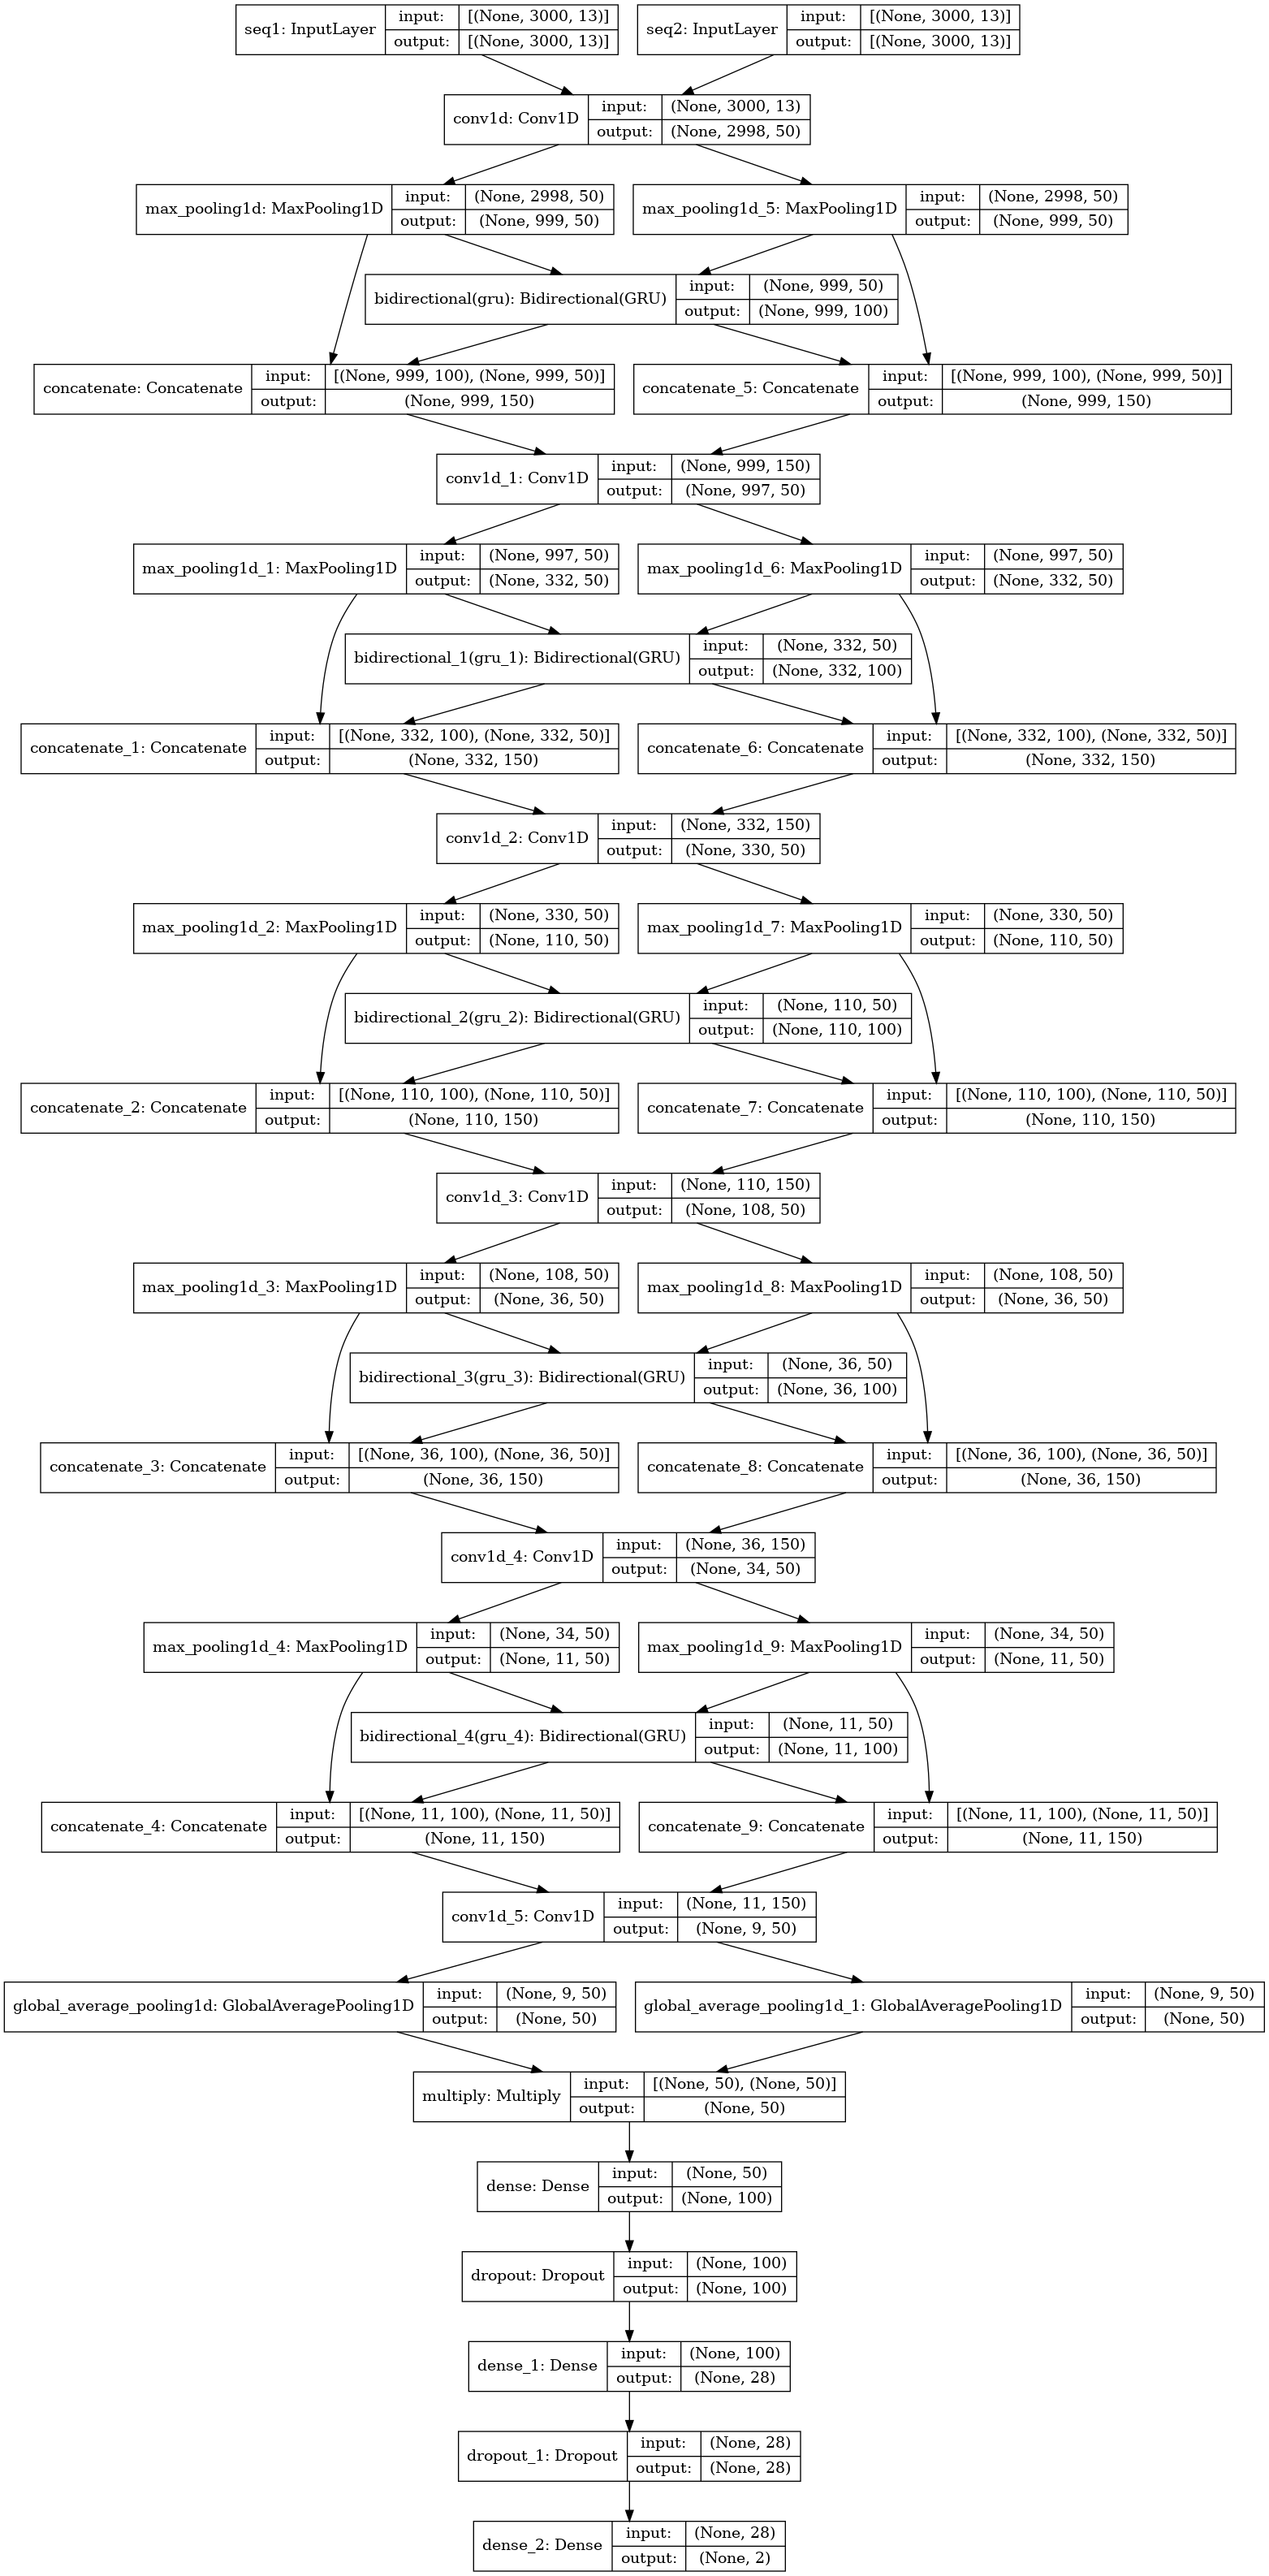

In [15]:
hparams = {
  HP_EPSILON: EPSILON,
  HP_LEARNING_RATE: LEARNING_RATE,
  HP_FIRST_DENSE: 100,
  HP_KERNEL_SIZE: 3,
  HP_POOLING_KERNEL: 3,
  HP_CONV_HIDDEN_DIM: 50,
  HP_RNN_HIDDEN_DIM: 50,
  HP_ACTIVATION: 'leaky_relu',
  HP_ACTIVATION_CONV: 'relu',
  HP_REGULARIZER: 0,
  HP_CONV_PADDING: 'valid',
  HP_DROPOUT: 3e-1,
  HP_BATCH_SIZE: 256,
  HP_LEAKY_RELU: 3e-1
}

model = build_model(hparams)
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

### Config Train-test process

In [16]:
def train_test_model(hparams):
    training_time = 1
    num_hit = 0.
    num_total = 0.
    num_pos = 0.
    num_true_pos = 0.
    num_false_pos = 0.
    num_true_neg = 0.
    num_false_neg = 0.
    
    for train, test in train_test:
        merge_model = None
        merge_model = build_model(hparams)  


        merge_model.compile(optimizer=Adam(learning_rate=hparams[HP_LEARNING_RATE], amsgrad=True, epsilon=hparams[HP_EPSILON]), 
                          loss='categorical_crossentropy', metrics=METRICS)
        # Create train
        train_dataset = tf.data.Dataset.from_generator(generator_pair, 
                                                     args=[train], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), 
                                                     output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
        train_dataset = train_dataset.shuffle(1024).repeat(N_EPOCHS).batch(hparams[HP_BATCH_SIZE])
        train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


        # Create val
        val_dataset = tf.data.Dataset.from_generator(generator_pair, 
                                                     args=[test], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), 
                                                     output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
        val_dataset = val_dataset.batch(hparams[HP_BATCH_SIZE])
        val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

        # Save the best model base on val_accuracy
        checkpoint = ModelCheckpoint(filepath='my_best_model.hdf5', 
                                     monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
        # Fit model
        print(f'==================== Training time  {training_time} =====================')
        merge_model.fit(train_dataset, steps_per_epoch=len(train)//hparams[HP_BATCH_SIZE], 
                        epochs=N_EPOCHS, validation_data=val_dataset, callbacks=[checkpoint, reduce_lr])

        print(f'==================End training {training_time}========================')
        # # Create test
        # test_dataset = tf.data.Dataset.from_generator(generator_pair, args=[test], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
        # test_dataset = test_dataset.batch(hparams[HP_BATCH_SIZE])
        # res = merge_model.evaluate(test_dataset)
        # Create pred
        pred_dataset = tf.data.Dataset.from_generator(generator_pair_predict, args=[test], output_types=({"seq1": DTYPE, "seq2": DTYPE}), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}) )
        pred_dataset = pred_dataset.batch(BATCH_SIZE)
        pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
        pred = merge_model.predict(pred_dataset)

      # Performance metrics
        for i in range(len(class_labels[test])):
            num_total += 1
            if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
                num_hit += 1
            if class_labels[test][i][0] > 0.:
                num_pos += 1.
                if pred[i][0] > pred[i][1]:
                    num_true_pos += 1
                else:
                    num_false_neg += 1
            else:
                if pred[i][0] > pred[i][1]:
                    num_false_pos += 1
                else:
                    num_true_neg += 1
                    
        accuracy = num_hit / num_total
        prec = num_true_pos / (num_true_pos + num_false_pos)
        recall = num_true_pos / num_pos
        spec = num_true_neg / (num_true_neg + num_false_neg)
        f1 = 2. * prec * recall / (prec + recall)
        mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_false_pos) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_true_neg + num_false_neg)) ** 0.5
        training_time += 1
        print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec}, mcc: {mcc} ,f1-score: {f1}')
    return accuracy

### Log configurations and accuracy

In [17]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

### Loop over all configurations

In [ ]:
if cross_validation == 0:
    merge_model = None
    merge_model = build_model(hparams)  


    merge_model.compile(optimizer=Adam(learning_rate=hparams[HP_LEARNING_RATE], 
                                       amsgrad=True, epsilon=hparams[HP_EPSILON]), 
                        loss='categorical_crossentropy', metrics=METRICS)
    # Create train
    train_dataset = tf.data.Dataset.from_generator(generator_pair, 
                                                   args=[seq_tensor, class_labels, np.arange(len(class_labels))], 
                                                   output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), 
                                                   output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
    train_dataset = train_dataset.shuffle(1024).repeat(N_EPOCHS).batch(hparams[HP_BATCH_SIZE])
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    
    # # Create test
    test_dataset = tf.data.Dataset.from_generator(generator_pair, args=[seq_tensor_, class_labels_, np.arange(len(class_labels_))], 
                                                  output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), 
                                                  output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
    test_dataset = test_dataset.batch(hparams[HP_BATCH_SIZE])
    

    # Save the best model base on val_accuracy
    checkpoint = ModelCheckpoint(filepath='pipr_best_model.hdf5', monitor='val_loss',verbose=1, 
                                 save_best_only=True, mode='min')
    
    # Fit model
    merge_model.fit(train_dataset, steps_per_epoch=len(train) // hparams[HP_BATCH_SIZE], 
                    epochs=N_EPOCHS, 
                    validation_data=test_dataset,
                    callbacks=[checkpoint, reduce_lr, early_stopping])


    # merge_model.evaluate(test_dataset)

Epoch 1/50


2022-03-07 09:39:24.083350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-07 09:39:27.067552: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2022-03-07 09:39:28.625168: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


174/174 [==============================] - 161s 805ms/step - loss: 0.6751 - accuracy: 0.5857 - precision: 0.5857 - recall: 0.5857 - mcc: 0.1326 - f1-score: 0.5219 - auc: 0.6122 - prc: 0.5941 - val_loss: 0.6685 - val_accuracy: 0.5949 - val_precision: 0.5949 - val_recall: 0.5949 - val_mcc: 0.1582 - val_f1-score: 0.5548 - val_auc: 0.6293 - val_prc: 0.6113

Epoch 00001: val_loss improved from inf to 0.66854, saving model to pipr_best_model.hdf5
Epoch 2/50


/home/wmbio/anaconda3/envs/pipr/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


174/174 [==============================] - 129s 743ms/step - loss: 0.6625 - accuracy: 0.6032 - precision: 0.6032 - recall: 0.6032 - mcc: 0.1783 - f1-score: 0.5735 - auc: 0.6423 - prc: 0.6248 - val_loss: 0.6159 - val_accuracy: 0.6733 - val_precision: 0.6733 - val_recall: 0.6733 - val_mcc: 0.3333 - val_f1-score: 0.6504 - val_auc: 0.7228 - val_prc: 0.7060

Epoch 00002: val_loss improved from 0.66854 to 0.61589, saving model to pipr_best_model.hdf5
Epoch 3/50
174/174 [==============================] - 130s 748ms/step - loss: 0.5066 - accuracy: 0.7547 - precision: 0.7547 - recall: 0.7547 - mcc: 0.5016 - f1-score: 0.7496 - auc: 0.8330 - prc: 0.8289 - val_loss: 0.3534 - val_accuracy: 0.8531 - val_precision: 0.8531 - val_recall: 0.8531 - val_mcc: 0.7025 - val_f1-score: 0.8500 - val_auc: 0.9238 - val_prc: 0.9219

Epoch 00003: val_loss improved from 0.61589 to 0.35339, saving model to pipr_best_model.hdf5
Epoch 4/50
174/174 [==============================] - 129s 740ms/step - loss: 0.2793 - accu